In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matchPics import matchPics
from helper import plotMatches
from planarH import computeH
from planarH import warped, computeH_norm, computeH_ransac, computeH_ransac_adaptive

In [2]:
cv_cover = cv2.imread('../data/cv_cover.jpg')
cv_desk = cv2.imread('../data/cv_desk.png')

### Matching 잘 된 것들만 모아서 homography 계산

In [3]:

matches, locs1, locs2 = matchPics(cv_cover, cv_desk)
matched_pts1 = locs1[matches[:, 0],:2]
matched_pts2 = locs2[matches[:, 1],:2]

x1 = np.array([matched_pts1[10], matched_pts1[37], matched_pts1[42], matched_pts1[43], matched_pts1[19], matched_pts1[23], matched_pts1[31], matched_pts1[49], matched_pts1[57], matched_pts1[58], matched_pts1[60]], np.float32)
x2 = np.array([matched_pts2[10], matched_pts2[37], matched_pts2[42], matched_pts2[43], matched_pts2[19], matched_pts2[23], matched_pts2[31], matched_pts2[49], matched_pts2[57], matched_pts2[58], matched_pts2[60]], np.float32)


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
H2to1 = computeH(x2, x1)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('warped_cover')
plt.show()

result = warped(H2to1, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

### Matching된 61개 모두 사용

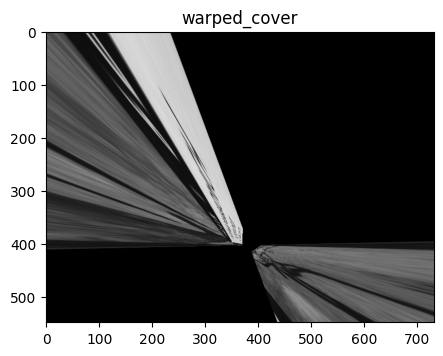

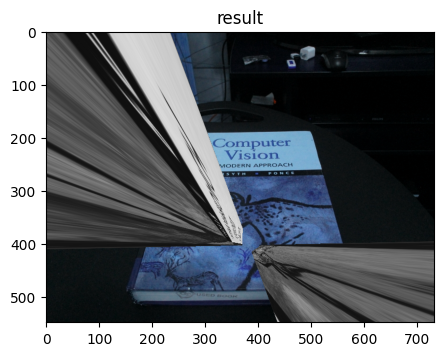

In [ ]:
H2to1 = computeH(matched_pts2, matched_pts1)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('warped_cover')
plt.show()

result = warped(H2to1, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

In [ ]:
def warped(H2to1, template, img):
    # Create a composite image after warping the template image on top
    # of the image using the homography

    # Note that the homography we compute is from the image to the template;
    # x_template = H2to1*x_photo
    # For warping the template to the image, we need to invert it.

    # Create mask of same size as template
    mask = np.ones_like(template)

    # Warp mask by appropriate homography
    warped_mask = cv2.warpPerspective(mask, H2to1, (img.shape[1], img.shape[0]))

    # Warp template by appropriate homography
    warped_template = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]))

    # Use mask to combine the warped template and the image
    composite_img = img.copy()
    composite_img[warped_mask == 1] = warped_template[warped_mask == 1]

    return composite_img

### GT로 코드 체크

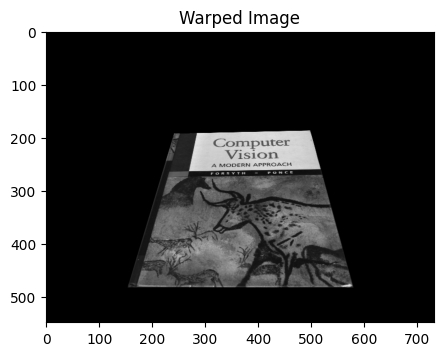

(548, 731, 3)


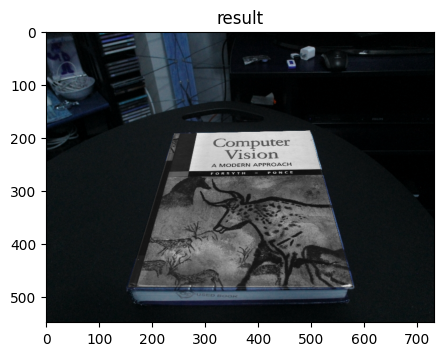

[[-2.28191547e-03  1.08761396e-03 -7.80545925e-01]
 [ 9.09771366e-05 -7.36963941e-04 -6.25084496e-01]
 [ 1.88749246e-07  2.89454619e-06 -3.23877977e-03]]


In [21]:
x3 = np.array([[0., 0.],
               [0., 439.],
               [349., 439.],
               [349., 0.]], np.float32)

x4 = np.array([[241., 193.],
               [154., 482.],
               [578., 482.],
               [497., 187.]], np.float32)

H2to1 = computeH(x4, x3)
              
h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()
              
result = warped(H2to1, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()
print(H2to1)

## OpenCV ORB

### Best matches

In [3]:
# Load images
# Detect keypoints and extract descriptors
orb = cv2.ORB_create(nfeatures=40000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=31,
    fastThreshold=20)

kp1, des1 = orb.detectAndCompute(cv_cover, None)
kp2, des2 = orb.detectAndCompute(cv_desk, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1, des2)

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches_cv]).reshape(-1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches_cv]).reshape(-1, 2)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

# Select the top 10% accurate matches
num_matches_10 = int(len(matches_cv) * 0.1)  # choose 10% of total matches
best_matches_10 = matches_cv[:num_matches_10]

pts1_best_10 = np.float32([kp1[m.queryIdx].pt for m in best_matches_10]).reshape(-1, 2)
pts2_best_10 = np.float32([kp2[m.trainIdx].pt for m in best_matches_10]).reshape(-1, 2)


num_matches_50 = int(len(matches_cv) * 0.5)  # choose 10% of total matches
best_matches_50 = matches_cv[:num_matches_50]

pts1_best_50 = np.float32([kp1[m.queryIdx].pt for m in best_matches_50]).reshape(-1, 2)
pts2_best_50 = np.float32([kp2[m.trainIdx].pt for m in best_matches_50]).reshape(-1, 2)


### Basic homography

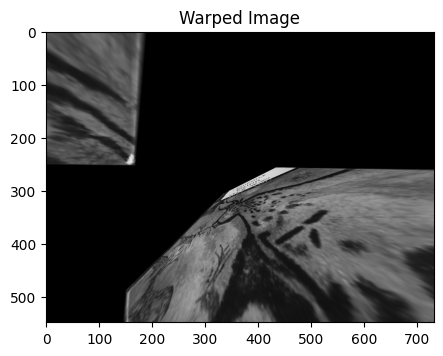

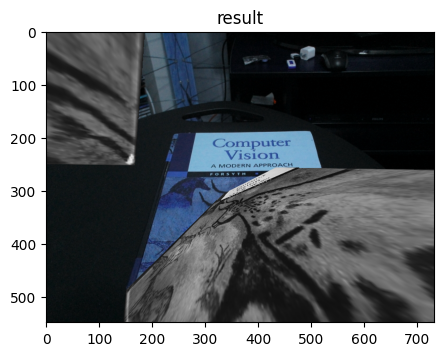

In [16]:
# Compute homography matrix
#H2to1, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

H2to1 = computeH(pts2_best_10, pts1_best_10)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

### Normalized

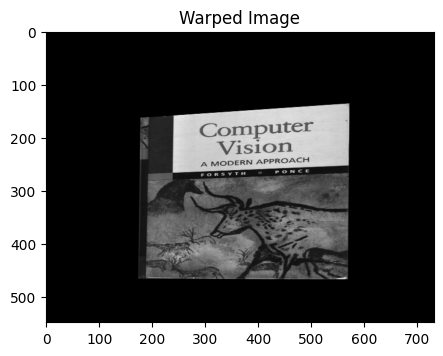

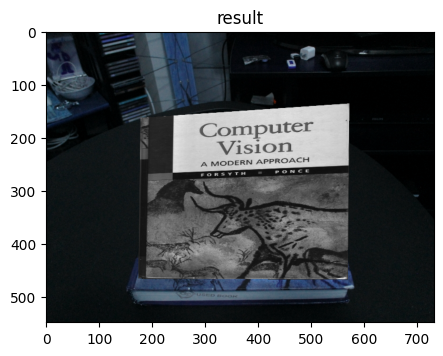

In [7]:
# Compute homography matrix
#H2to1, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

H2to1_norm = computeH_norm(pts2_best_10, pts1_best_10)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1_norm, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1_norm, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

### RANSAC

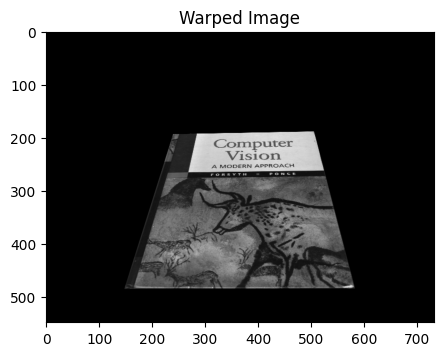

(365, 274)


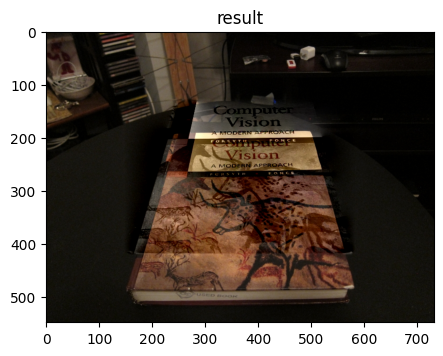

In [4]:
# Compute homography matrix
#H2to1_ransac, inliers = cv2.findHomography(pts1_best_30, pts2_best_30"=, cv2.RANSAC, 5.0)
H2to1_ransac, inliers = computeH_ransac(pts2_best_10, pts1_best_10, 1000)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1_ransac, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1_ransac, cv_cover, cv_desk)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

In [23]:
pts1_best_50.shape

(63, 2)

In [24]:
pts2_best_50.shape

(63, 2)

### Adaptive RANSAC

894863
36
32
28
28


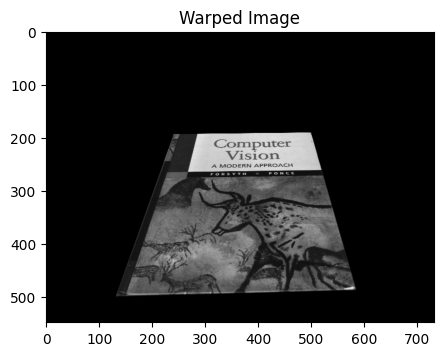

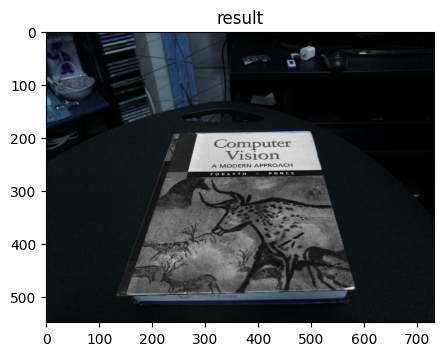

In [11]:
# Compute homography matrix
#H2to1_ransac, inliers = cv2.findHomography(pts1_best_30, pts2_best_30"=, cv2.RANSAC, 5.0)
H2to1_ransac, inliers = computeH_ransac_adaptive(pts2_best_50, pts1_best_50, 3000)

h, w = cv_desk.shape[:2]

warped_cover = cv2.warpPerspective(cv_cover, H2to1_ransac, (w, h))

plt.figure(figsize=(5, 5))
plt.imshow(warped_cover)
plt.title('Warped Image')
plt.show()

result = warped(H2to1_ransac, cv_cover, cv_desk)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()